<a href="https://colab.research.google.com/github/gourabdg47/Convolutional_Autoencoder_prac/blob/master/autoencoder_prac_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [0]:
import keras
import pandas as pd
from matplotlib import pyplot as plt
import gzip
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
import numpy as np
from sklearn.model_selection import train_test_split

In [0]:
def extract_data(filename, num_images):
  with gzip.open(filename) as bytestream:
    bytestream.read(16)
    buf = bytestream.read(28 * 28 * num_images)
    image = np.frombuffer(buf, dtype = np.uint8).astype(np.float32)
    image = image.reshape(num_images, 28 * 28)
    
    return image

In [0]:
def extract_label(filename, num_images):
  with gzip.open(filename) as bytestream:
    bytestream.read(8)
    buf_label = bytestream.read(1 * num_images)
    label = np.frombuffer(buf_label, dtype = np.uint8).astype(np.int64)
    
    return label

In [65]:
cd /content/drive

[Errno 2] No such file or directory: '/content/drive'
/content


In [66]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train_data = extract_data('/content/gdrive/My Drive/deep_learning_practice/data/notMNIST/copy_of_train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('/content/gdrive/My Drive/deep_learning_practice/data/notMNIST/copy_of_t10k-images-idx3-ubyte.gz', 10000)

In [0]:
train_label = extract_label('/content/gdrive/My Drive/deep_learning_practice/data/notMNIST/train-labels-idx1-ubyte.gz', 60000)
test_label = extract_label('/content/gdrive/My Drive/deep_learning_practice/data/notMNIST/t10k-labels-idx1-ubyte.gz', 10000)

In [69]:
print(np.shape(train_data))
print(np.shape(test_data))
print(type(test_data))

(60000, 784)
(10000, 784)
<class 'numpy.ndarray'>


In [0]:
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

In [71]:
train_data = train_data.reshape(-1, 28, 28, 1)
test_data = test_data.reshape(-1, 28, 28, 1)

train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [72]:
train_data.dtype

dtype('float32')

In [73]:
# rescaleing the pixel values in range 0 - 1 inclusive(training and testing data with the maximum pixel value of the training and testing data)

train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [0]:
# Note that for this task, you don't need training and testing labels. That's why you will pass the training images twice. Your training images will both act as the input as well as the ground truth similar to the labels you have in classification task.

train_x, valid_x, train_ground,valid_ground = train_test_split(train_data, train_data, test_size = 0.2, random_state = 13)

In [75]:
train_x.shape, valid_x.shape, train_ground.shape, valid_ground.shape

((48000, 28, 28, 1),
 (12000, 28, 28, 1),
 (48000, 28, 28, 1),
 (12000, 28, 28, 1))

In [0]:
batch_size = 128
epoch = 25
inChannel = 1
x, y = 28, 28
input_image = Input(shape = (x, y, inChannel))

In [0]:
def autoencoder(input_image):
  
  #encoder
  #input 28 * 28 * 1
  
  conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_image) # 28 x 28 x 32
  pool1 = MaxPooling2D(pool_size = (2, 2))(conv1) # 14 * 14 * 32
  conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(pool1)
  pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
  conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool2)
  
  #decoder
  conv4 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv3)
  dpool4 = UpSampling2D((2, 2))(conv4)
  conv5 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(dpool4)
  dpool5 = UpSampling2D((2, 2))(conv5)
  decoded = Conv2D(1, (3, 3), activation = 'relu', padding = 'same')(dpool5)
  
  return decoded 
  
  

In [0]:
autoencoder = Model(input_image, autoencoder(input_image))
autoencoder.compile(loss = 'mean_squared_error', optimizer = RMSprop())

In [79]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 128)         147584    
__________

In [80]:
autoencoder_train = autoencoder.fit(train_x, train_ground, batch_size = batch_size, epochs = epoch, verbose = 1, validation_data = (valid_x, valid_ground))

Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 12s 251us/step - loss: 0.0610 - val_loss: 0.0149
Epoch 2/25
48000/48000 [==============================] - 12s 243us/step - loss: 0.0151 - val_loss: 0.0117
Epoch 3/25
48000/48000 [==============================] - 12s 243us/step - loss: 0.0100 - val_loss: 0.0076
Epoch 4/25
48000/48000 [==============================] - 12s 241us/step - loss: 0.0075 - val_loss: 0.0067
Epoch 5/25
48000/48000 [==============================] - 12s 243us/step - loss: 0.0062 - val_loss: 0.0050
Epoch 6/25
48000/48000 [==============================] - 12s 243us/step - loss: 0.0054 - val_loss: 0.0053
Epoch 7/25
48000/48000 [==============================] - 12s 243us/step - loss: 0.0048 - val_loss: 0.0042
Epoch 8/25
48000/48000 [==============================] - 12s 241us/step - loss: 0.0044 - val_loss: 0.0049
Epoch 9/25
48000/48000 [==============================] - 12s 242us/step - loss: 0.0041 - val_

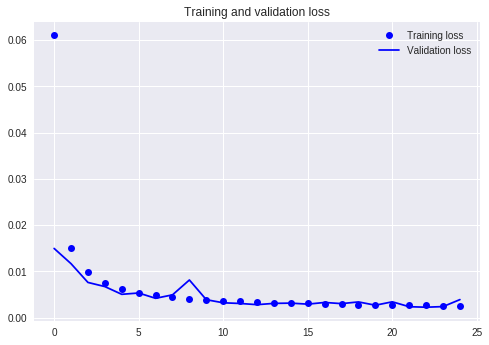

In [84]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epoch)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [86]:
pred = autoencoder.predict(test_data)
pred.shape

(10000, 28, 28, 1)

Test Images


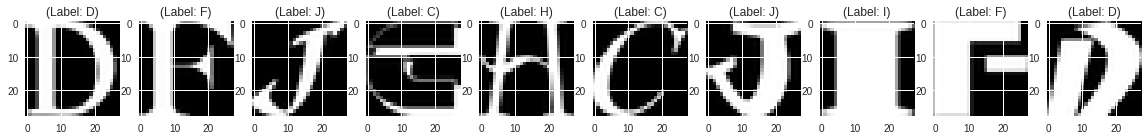

Reconstruction of Test Images


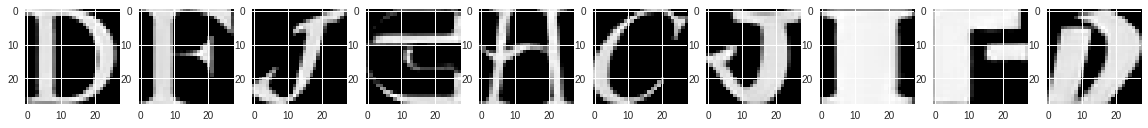

In [88]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_label[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [0]:
# Denoising Autoencoder soon coming ...